#Synthetic EV charging data

In [1]:
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from collections import deque
import matplotlib.pyplot as plt
number_of_EVs = 10
number_of_hours= 5 # Simulation Time-step (Use the number of hours according to your available dataset)
hourly_chargingstation_limit = np.random.randint(8, 15, number_of_hours)
hourly_arrival = np.random.randint(1, number_of_hours- 1, number_of_EVs)
soc_at_arrival = np.random.randint(60, 70, number_of_EVs)
soc_desired = np.random.randint(80, 100, number_of_EVs)
kwh_rate = np.random.randint(15, 40, number_of_EVs)
battery_capacity = 100
kwh_required = (soc_desired - soc_at_arrival) / 100 * battery_capacity
charging_duration = np.ceil(kwh_required / kwh_rate).astype(int)
ev_sessions = pd.DataFrame({'Charging session': np.arange(1, number_of_EVs + 1),
'hourly_arrival': hourly_arrival, 'soc_at_arrival': soc_at_arrival, 'soc_desired': soc_desired, 'kwh_rate': kwh_rate,
 'kwh_required': kwh_required, 'charging_duration': charging_duration})
hourly_max_capacity_of_chargingstations = pd.DataFrame({
    'Hour': np.arange(number_of_hours),
    'ChargingStationLimit': hourly_chargingstation_limit})
display(ev_sessions)
display(hourly_max_capacity_of_chargingstations)

,Charging session,hourly_arrival,soc_at_arrival,soc_desired,kwh_rate,kwh_required,charging_duration
0,1,3,62,85,31,23.0,1
1,2,2,64,87,23,23.0,1
2,3,3,61,91,27,30.0,2
3,4,1,67,97,39,30.0,1
4,5,1,69,99,27,30.0,2
5,6,1,60,91,28,31.0,2
6,7,1,60,80,30,20.0,1
7,8,3,64,85,16,21.0,2
8,9,1,65,87,24,22.0,1
9,10,1,62,93,29,31.0,2


,Hour,ChargingStationLimit
0,0,12
1,1,12
2,2,11
3,3,13
4,4,8


#Buffer, actor network, and critic netowork for MADDPG

In [2]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    def add(self, experience):
        self.buffer.append(experience)
    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), size=batch_size)
        return [self.buffer[i] for i in indices]
    def size(self):
        return len(self.buffer)
def create_actor():
    model = models.Sequential()
    model.add(layers.Input(shape=(number_of_hours + 2,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(len(action_space), activation='softmax'))
    return model
def create_critic():
    model = models.Sequential()
    model.add(layers.Input(shape=(number_of_hours + 2 + len(action_space),)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    return model

#Initialization

In [3]:
learning_rate = 0.001
gamma = 0.95
batch_size = 64
memory_size = 10000
action_space = [0, 1]  # Actions: Not Charging=0, Charging=1
reward_history = []
Total_episodes=100
replay_buffer = ReplayBuffer(memory_size)
actors = [create_actor() for _ in range(number_of_EVs)]
critics = [create_critic() for _ in range(number_of_EVs)]
target_actors = [create_actor() for _ in range(number_of_EVs)]
target_critics = [create_critic() for _ in range(number_of_EVs)]
actor_optimizers = [optimizers.Adam(learning_rate) for _ in range(number_of_EVs)]
critic_optimizers = [optimizers.Adam(learning_rate) for _ in range(number_of_EVs)]

#Training MADDPG

In [4]:
for episode in range(Total_episodes):
    #Environment Initialization
    states = np.random.uniform(0, 1, (number_of_EVs, number_of_hours + 2))
    soc_levels = np.random.uniform(0.1, 0.5, number_of_EVs)
    total_reward = 0
    #Training Loop
    for t in range(number_of_hours):

        actions = []
        for ev in range(number_of_EVs):
            if np.random.rand() < 0.1:
                action = random.choice(action_space)
            else:
                probs = actors[ev](states[ev:ev+1])
                action = np.argmax(probs)
            actions.append(action)
        remaining_charging_sessions = [charging_duration[ev] for ev in range(number_of_EVs)]
        charging_priority = np.argsort(remaining_charging_sessions)
        charging_evs = []
        for ev in charging_priority:
            if actions[ev] == 1 and charging_duration[ev] > 0:
                if len(charging_evs) < hourly_chargingstation_limit[t]:
                    charging_evs.append(ev)
                    charging_duration[ev] -= 1
        else:
                actions[ev] = 0
        rewards = []
        next_states = states.copy()
        for ev in range(number_of_EVs):
            if actions[ev] == 1:
                soc_levels[ev] = min(soc_levels[ev] + (kwh_rate[ev] / battery_capacity), 1.0)
                reward = soc_levels[ev]
            else:
                reward = -1
            rewards.append(reward)
            next_states[ev] = next_states[ev] + np.random.normal(0, 0.1, next_states[ev].shape)
        total_reward += np.sum(rewards)
        done = t == number_of_hours - 1
        for ev in range(number_of_EVs):
            replay_buffer.add((states[ev], actions[ev], rewards[ev], next_states[ev], done))
        if replay_buffer.size() > batch_size:
            minibatch = replay_buffer.sample(batch_size)
            for ev in range(number_of_EVs):
                states_mb, actions_mb, rewards_mb, next_states_mb, dones_mb = zip(*minibatch)
                states_mb = np.array(states_mb)
                actions_mb = np.array(actions_mb)
                rewards_mb = np.array(rewards_mb)
                next_states_mb = np.array(next_states_mb)
                dones_mb = np.array(dones_mb)
                target_actions = [target_actors[i](next_states_mb) for i in range(number_of_EVs)]
                target_q_values = target_critics[ev](np.hstack([next_states_mb, target_actions[ev]]))
                y = rewards_mb + gamma * target_q_values * (1 - dones_mb)
                with tf.GradientTape() as tape:
                    actions_mb_one_hot = tf.one_hot(actions_mb, depth=len(action_space))
                    q_values = critics[ev](tf.concat([states_mb, tf.cast(actions_mb_one_hot, tf.float32)], axis=1))
                    critic_loss = tf.reduce_mean(tf.square(y - q_values))
                critic_grads = tape.gradient(critic_loss, critics[ev].trainable_variables)
                critic_optimizers[ev].apply_gradients(zip(critic_grads, critics[ev].trainable_variables))
                with tf.GradientTape() as tape:
                    actions_pred = actors[ev](states_mb)
                    actions_pred_one_hot = actions_pred
                    actor_loss = -tf.reduce_mean(critics[ev](tf.concat([states_mb, actions_pred_one_hot], axis=1)))
                actor_grads = tape.gradient(actor_loss, actors[ev].trainable_variables)
                actor_optimizers[ev].apply_gradients(zip(actor_grads, actors[ev].trainable_variables))
        for ev in range(number_of_EVs):
            target_actors[ev].set_weights([0.995 * w + 0.005 * tw for w, tw in zip(actors[ev].get_weights(), target_actors[ev].get_weights())])
            target_critics[ev].set_weights([0.995 * w + 0.005 * tw for w, tw in zip(critics[ev].get_weights(), target_critics[ev].get_weights())])
        states = next_states
    reward_history.append(total_reward)
    print(f"Episode {episode + 1}: Total Reward - {total_reward}")

Episode 1: Total Reward - -15.443340066476143
Episode 2: Total Reward - -5.174697727285201
Episode 3: Total Reward - -4.833716302713155
Episode 4: Total Reward - 1.5777609353222175
Episode 5: Total Reward - 3.9412184216255306
Episode 6: Total Reward - -4.16353351279952
Episode 7: Total Reward - -2.807170894926659
Episode 8: Total Reward - -8.58349536481234
Episode 9: Total Reward - 3.896255616355792
Episode 10: Total Reward - 10.46960307574609
Episode 11: Total Reward - 8.864974067833895
Episode 12: Total Reward - 12.460550018941483
Episode 13: Total Reward - 5.030104857276811
Episode 14: Total Reward - 11.486036710562745
Episode 15: Total Reward - 7.581515165266781
Episode 16: Total Reward - 6.406521354404456
Episode 17: Total Reward - 9.762278447108997
Episode 18: Total Reward - 23.07679623725098
Episode 19: Total Reward - 25.208168026881673
Episode 20: Total Reward - 32.771805965549675
Episode 21: Total Reward - 31.03483508681152
Episode 22: Total Reward - 30.229476900262355
Episode

#Reward Curve

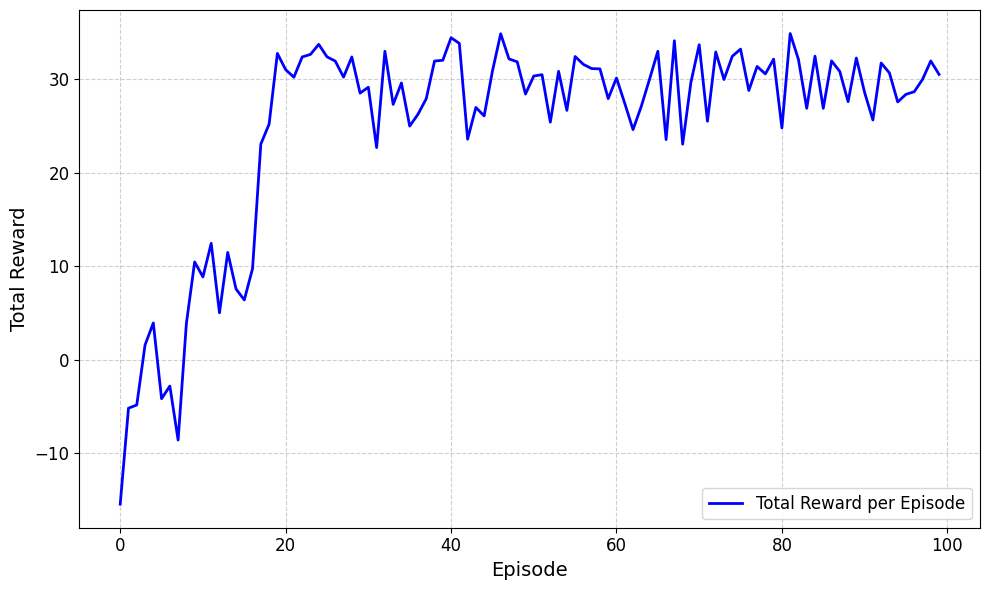

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(reward_history, label='Total Reward per Episode', color='b', linewidth=2)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Total Reward', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#Optimal Actions

In [8]:
optimal_actions = []
for ev in range(number_of_EVs):
    state = np.random.uniform(0, 1, (1, number_of_hours + 2))  # Example random state with more features
    probs = actors[ev](state)
    optimal_action = np.argmax(probs)
    optimal_actions.append(optimal_action)
ev_optimal_actions = pd.DataFrame({'Session': np.arange(1, number_of_EVs + 1),
    'Optimal Action': optimal_actions})
print(ev_optimal_actions)

   Session  Optimal Action
0        1               1
1        2               1
2        3               1
3        4               1
4        5               1
5        6               1
6        7               1
7        8               1
8        9               1
9       10               1
